[*********************100%%**********************]  1 of 1 completed


|   iter    |  target   | n_comp... |
-------------------------------------
| 1         | 0.05799   | 2.749     |
| 2         | -0.2793   | 3.901     |
| 3         | -0.2793   | 3.464     |
| 4         | -0.2793   | 3.197     |
| 5         | -0.05799  | 2.312     |
| 6         | 0.05799   | 2.571     |
| 7         | 0.05799   | 2.571     |
| 8         | 0.05799   | 2.0       |
| 9         | 0.05799   | 2.662     |
| 10        | 0.05799   | 2.88      |
| 11        | 0.05799   | 2.097     |
| 12        | -0.05799  | 2.824     |
| 13        | 0.05799   | 2.978     |
| 14        | 0.05799   | 2.459     |
| 15        | -0.2793   | 3.682     |
| 16        | -0.05799  | 2.19      |
| 17        | 0.05799   | 2.93      |
| 18        | 0.154     | 3.056     |
| 19        | -0.01607  | 3.091     |
| 20        | -0.01607  | 3.027     |
| 21        | 0.05799   | 2.706     |
| 22        | 0.05799   | 2.048     |
| 23        | -0.05799  | 2.513     |
| 24        | -0.05799  | 2.616     |
| 25        

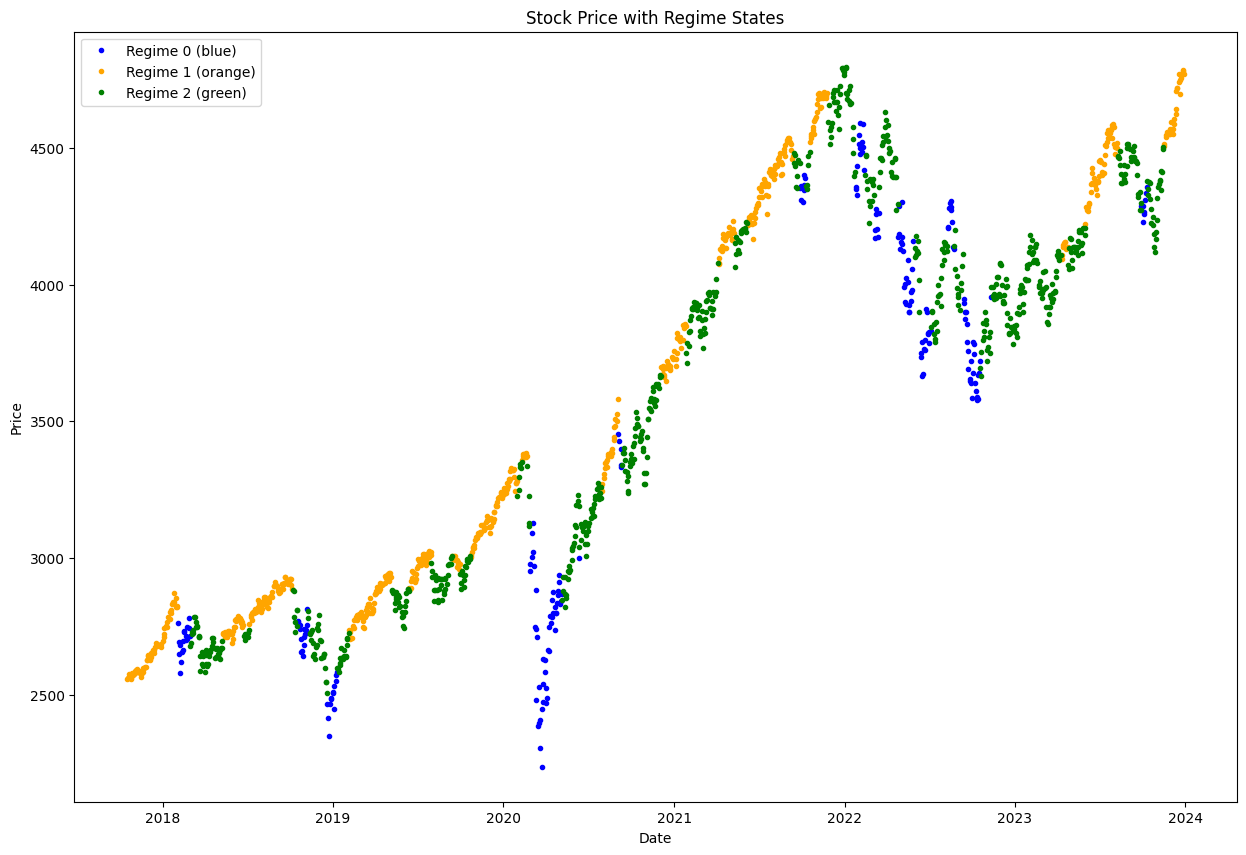

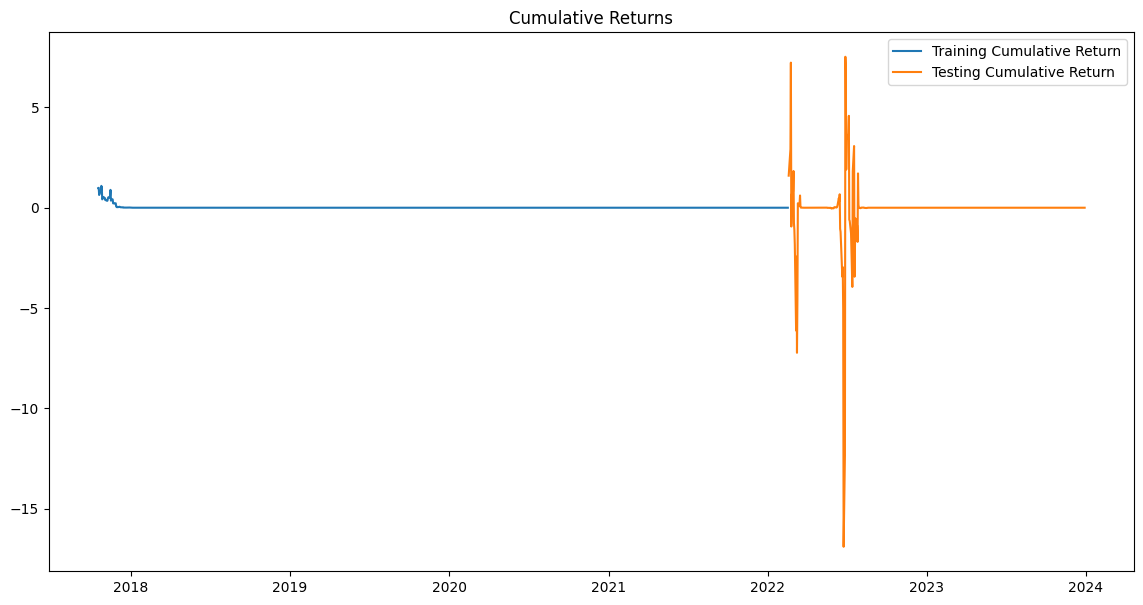

Training Set Performance:
Sharpe Ratio: -0.20
Annualized Sharpe Ratio: -3.12
Cumulative Return: -0.00
Total Trades: 16

Testing Set Performance:
Sharpe Ratio: 0.13
Annualized Sharpe Ratio: 2.01
Cumulative Return: 0.00
Total Trades: 14


In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# Step 1: Data Preparation
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

def calculate_features(data):
    df = pd.DataFrame(data)
    df['Returns'] = df['Adj Close'].pct_change()
    df['SMA50'] = df['Adj Close'].rolling(window=50).mean()
    df['SMA200'] = df['Adj Close'].rolling(window=200).mean()
    df['Volatility'] = df['Returns'].rolling(window=21).std()
    df['Momentum'] = df['Adj Close'].pct_change(periods=21)

    # Manually calculate RSI
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Manually calculate ADX
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Adj Close'].shift())
    low_close = np.abs(df['Low'] - df['Adj Close'].shift())
    tr = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close}).max(axis=1)
    tr_sma = tr.rolling(window=14).mean()

    up_move = df['High'] - df['High'].shift()
    down_move = df['Low'].shift() - df['Low']
    plus_dm = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0), index=df.index)
    minus_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0), index=df.index)

    plus_di = 100 * (plus_dm.rolling(window=14).mean() / tr_sma)
    minus_di = 100 * (minus_dm.rolling(window=14).mean() / tr_sma)

    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    df['ADX'] = dx.rolling(window=14).mean()

    df.dropna(inplace=True)

    scaler = StandardScaler()
    df[['Returns', 'Volatility', 'Momentum', 'RSI', 'ADX']] = scaler.fit_transform(df[['Returns', 'Volatility', 'Momentum', 'RSI', 'ADX']])
    return df

# Step 2: Regime Switching Model with HMM
def fit_hmm(df, n_components):
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=20000, tol=0.0001)
    model.fit(df[['Returns', 'Volatility', 'Momentum', 'RSI', 'ADX']])
    hidden_states = model.predict(df[['Returns', 'Volatility', 'Momentum', 'RSI', 'ADX']])
    return model, hidden_states

def generate_signals(hidden_states):
    signals = np.where(hidden_states == 0, 1, -1)
    return signals

# Step 3: Backtesting
def backtest_strategy(df, signals, stop_loss, take_profit):
    df['Signal'] = signals
    df['Strategy'] = df['Signal'].shift(1) * df['Returns']
    df['Cumulative Return'] = (df['Strategy'] + 1).cumprod()
    df['Position'] = np.nan

    for i in range(1, len(df)):
        if df['Signal'].iloc[i] == 1 and (df['Adj Close'].iloc[i] / df['Adj Close'].iloc[i-1] - 1) < -stop_loss:
            df.loc[df.index[i], 'Position'] = 0  # Stop-loss
        elif df['Signal'].iloc[i] == 1 and (df['Adj Close'].iloc[i] / df['Adj Close'].iloc[i-1] - 1) > take_profit:
            df.loc[df.index[i], 'Position'] = 0  # Take-profit
        else:
            df.loc[df.index[i], 'Position'] = df['Signal'].iloc[i]

    df['Position'] = df['Position'].ffill()
    df['Strategy with SL TP'] = df['Position'].shift(1) * df['Returns']
    df['Cumulative Return with SL TP'] = (df['Strategy with SL TP'] + 1).cumprod()
    return df

# Step 4: Performance Evaluation
def calculate_performance(df):
    sharpe_ratio = np.mean(df['Strategy']) / np.std(df['Strategy']) * np.sqrt(252)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    cumulative_return = df['Cumulative Return'].iloc[-1]
    total_trades = np.sum(df['Signal'].diff().abs() > 0)
    return sharpe_ratio, sharpe_ratio_annualized, cumulative_return, total_trades

# Step 5: Optimization and Fine-tuning
def bayesian_optimization(df, pbounds, init_points, n_iter):
    def optimize_hmm(n_components):
        n_components = int(n_components)
        model, hidden_states = fit_hmm(df, n_components)
        signals = generate_signals(hidden_states)
        df_backtest = backtest_strategy(df, signals, stop_loss=0.02, take_profit=0.05)
        sharpe_ratio, sharpe_ratio_annualized, _, _ = calculate_performance(df_backtest)
        return sharpe_ratio

    optimizer = BayesianOptimization(f=optimize_hmm, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    return optimizer.max['params']

# Plot Regimes
def plot_regimes(df, hidden_states):
    plt.figure(figsize=(15, 10))
    regimes = np.unique(hidden_states)
    colors = ['blue', 'orange', 'green']

    for i, regime in enumerate(regimes):
        mask = hidden_states == regime
        plt.plot(df.index[mask], df['Adj Close'][mask], '.', label=f'Regime {regime} ({colors[i % len(colors)]})', color=colors[i % len(colors)])

    plt.legend()
    plt.title('Stock Price with Regime States')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# Main Function
def main():
    # Data Preparation
    start_date = "2017-01-01"
    end_date = "2023-12-31"
    data = get_sp500_data(start_date, end_date)
    df = calculate_features(data)

    # Split Data
    df_train, df_test = train_test_split(df, test_size=0.3, shuffle=False)

    # Bayesian Optimization
    pbounds = {'n_components': (2, 4)}  # Adjusting to include up to 4 components
    optimal_params = bayesian_optimization(df_train, pbounds, init_points=5, n_iter=20)

    # Fit HMM with optimal parameters
    n_components = int(optimal_params['n_components'])
    model, hidden_states = fit_hmm(df, n_components)
    signals = generate_signals(hidden_states)

    # Plot regimes
    plot_regimes(df, hidden_states)

    # Backtest on training set
    df_train_backtest = backtest_strategy(df_train, signals[:len(df_train)], stop_loss=0.02, take_profit=0.05)

    # Performance Evaluation on training set
    sharpe_ratio_train, sharpe_ratio_annualized_train, cumulative_return_train, total_trades_train = calculate_performance(df_train_backtest)

    # Backtest on testing set
    signals_test = generate_signals(hidden_states[len(df_train):])
    df_test_backtest = backtest_strategy(df_test, signals_test, stop_loss=0.02, take_profit=0.05)

    # Performance Evaluation on testing set
    sharpe_ratio_test, sharpe_ratio_annualized_test, cumulative_return_test, total_trades_test = calculate_performance(df_test_backtest)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df_train_backtest['Cumulative Return'], label='Training Cumulative Return')
    plt.plot(df_test_backtest['Cumulative Return'], label='Testing Cumulative Return')
    plt.legend()
    plt.title('Cumulative Returns')
    plt.show()

    # Display results
    print("Training Set Performance:")
    print(f"Sharpe Ratio: {sharpe_ratio_train:.2f}")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized_train:.2f}")
    print(f"Cumulative Return: {cumulative_return_train:.2f}")
    print(f"Total Trades: {total_trades_train}")

    print("\nTesting Set Performance:")
    print(f"Sharpe Ratio: {sharpe_ratio_test:.2f}")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized_test:.2f}")
    print(f"Cumulative Return: {cumulative_return_test:.2f}")
    print(f"Total Trades: {total_trades_test}")

if __name__ == "__main__":
    main()
